In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast/uncertainty


In [2]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Input, BatchNormalization, Lambda, 
                                     concatenate, Embedding, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import BatchCreator, Logger
from model_builder import get_pinball_losses, get_simple_dist_model, get_simple_dense_model
from flow import model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model
from preprocess import preprocess, get_features, pandas_cat_data


# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Optimise MLP - level 10 - entity embedding - part 2
See:  
Cheng Guo and Felix Berkhahn, "Entity Embeddings of Categorical Variables", April 25, 2016, https://arxiv.org/pdf/1604.06737.pdf.

In [4]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [5]:
level = 10

model_dir = 'models/uncertainty/hyper_opt/level_{}/'.format(level)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

## Read data

In [6]:
if level <= 9:
    fn = data_dir + 'prep/level_{}_simple_fe_2011_01_29_2016_04_24_normalised_demand.pickle'.format(level)
else:
    fn = data_dir + 'prep/level_{}_simple_fe_2014_04_26_2016_04_24_normalised_demand.pickle'.format(level)

# check if already preprocessed
if os.path.exists(fn):
    data = pd.read_pickle(fn)
else:
    # choose number of years to include
    if level <= 9:
        n_years = 6  # all
    else:
        n_years = 2
    
    # preform preprocessing
    data = preprocess(level=level, n_years=n_years, save_prepared_dataset=True, data_dir=data_dir)
    
# set categorical features
data, available_cat_features = pandas_cat_data(data)

# select features
sell_price_features = ('sell_price' in data.columns)
features = get_features(level=level, sell_price_features=sell_price_features)
print(features)

['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'shift_t28', 'shift_t29', 'shift_t30', 'rolling_std_t7', 'rolling_std_t30', 'rolling_std_t60', 'rolling_std_t90', 'rolling_std_t180', 'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60', 'rolling_mean_t90', 'rolling_mean_t180', 'rolling_skew_t30', 'rolling_kurt_t30', 'year', 'month', 'week', 'day', 'dayofweek', 'is_year_end', 'is_year_start', 'is_quarter_end', 'is_quarter_start', 'is_month_end', 'is_month_start', 'is_weekend', 'cat_id', 'dept_id', 'item_id']


In [7]:
# Set the NaNs in these categories as a single element
for col in ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']:
    data[col] = data[col].cat.add_categories(-1).fillna(-1)

In [8]:
# re-index the categories to match the input of the Embedding layer

for col in available_cat_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

In [9]:
# re-set the categories as pandas categories for proper pd.get_dummies
for col in available_cat_features:
    data[col] = data[col].astype('category')

## Setup training

In [15]:
# going to evaluate with the last 28 days
x_train = data[data['date'] <= '2016-03-27']
y_train = x_train['demand']
x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
y_val = x_val['demand']
test = data[(data['date'] > '2016-04-24')]

In [16]:
def get_generators(batch_size=1024):
    labels = ['demand']
    train_batch_creator = BatchCreator(x_train, features, labels, categorical_features=available_cat_features,
                                      batch_size=batch_size)
    val_batch_creator = BatchCreator(x_val, features, labels, shuffle=False, ensure_all_samples=True,
                                     categorical_features=available_cat_features, batch_size=batch_size)
    
    return train_batch_creator, val_batch_creator

# setup for training
train_batch_creator, val_batch_creator = get_generators()

# determine model input shape
x, y = next(train_batch_creator.flow())
INP_SHAPE = x[0].shape

# make losses
losses = get_pinball_losses()

# lazy evaluation of model
def lazy_evaluate_model(model):
    metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
    return metrics, df

## Reference: train Dist(256) model

In [18]:
# setup
model = get_simple_dist_model(inp_shape=INP_SHAPE, num_nodes=256)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=losses)
model.summary()
logger = Logger(val_batch_creator)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3230)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          827136      input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          65792       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          65792       dense_1[0][0]                    
______________________________________________________________________________________________

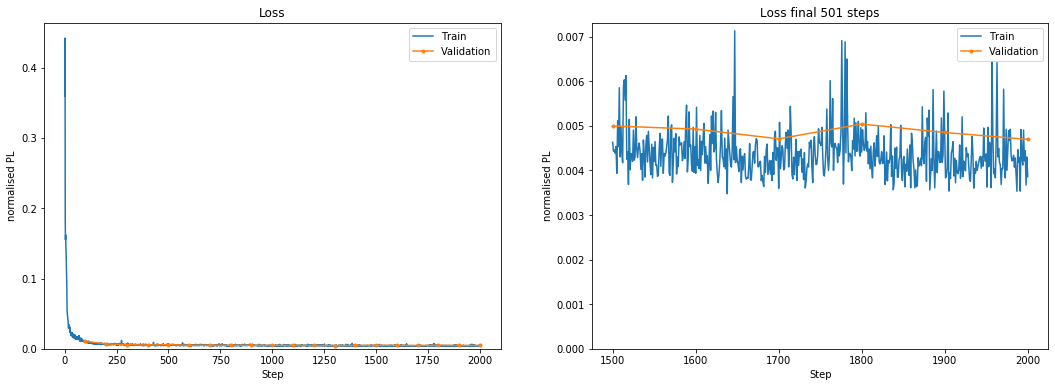

100/100 [==============================] - 43s 433ms/step - loss: 0.0043 - q0_loss: 3.7463e-05 - q1_loss: 1.3948e-04 - q2_loss: 5.6628e-04 - q3_loss: 7.3190e-04 - q4_loss: 9.7564e-04 - q5_loss: 8.3725e-04 - q6_loss: 6.8463e-04 - q7_loss: 2.1254e-04 - q8_loss: 8.3352e-05 - val_loss: 0.0047 - val_q0_loss: 5.2675e-05 - val_q1_loss: 1.6582e-04 - val_q2_loss: 6.4059e-04 - val_q3_loss: 8.2930e-04 - val_q4_loss: 0.0011 - val_q5_loss: 9.0487e-04 - val_q6_loss: 7.3113e-04 - val_q7_loss: 2.1551e-04 - val_q8_loss: 7.5946e-05


In [19]:
# train
history = model.fit(train_batch_creator.flow(), epochs=20, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 0.22401022421655362, 'WSPL': 0.22401022421655362}


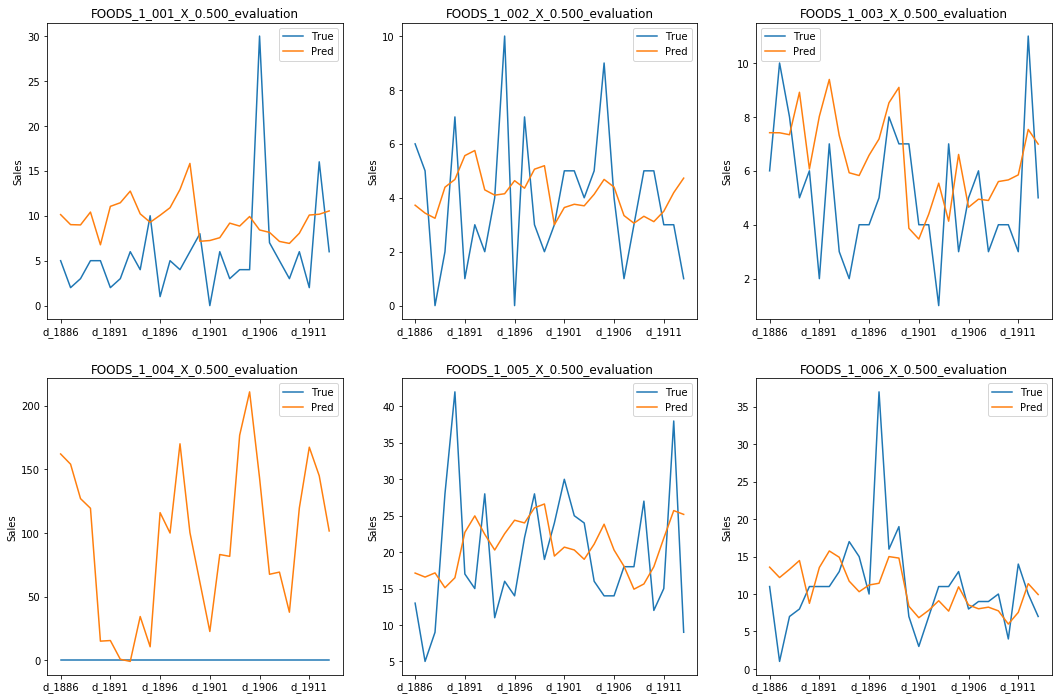

In [20]:
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

## Determine effectivenet of Embedding layer

### Step 1: Obtain multi-input for certain categorical features

In [54]:
class BatchCreator(Sequence):
    """Batch creator for M5 Uncertainty challenge.
    - batch_size: number of samples per batch. Note: if ensure_all_samples is True,
                  the final batch size may be smaller.
    - shuffle: whether to shuffle the samples.
    - ensure_all_samples: whether to ensure all samples are yielded. If False (default),
                          the batch size is always constant.
    - inp_shape: input shape of how a single sample enters the neural network. This is without the batch size.
    - categorical_features: which columns to convert to one-hot encoding
    """

    def __init__(self, df, features, labels, batch_size=128, shuffle=True, ensure_all_samples=False,
                 categorical_features=None, embedding_features=None):
        if embedding_features is None:
            embedding_features = []
        """Initialization"""
        # Save settings
        self.df = df
        self.list_IDs = self.df.index
        # exclude embedding features from 'normal features'
        self.features = [f for f in features if not f in embedding_features]
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.ensure_all_samples = ensure_all_samples
        # filter categorical features to which should be included
        self.categorical_features = [c for c in categorical_features
                                     if c in features
                                     and c not in embedding_features]
        self.embedding_features = embedding_features
        
        # initialize indices
        self.indexes = None
        self.on_epoch_end()

        # calculate properties
        self.n = self.df.index.size

    def __len__(self):
        """Denotes the number of batches per epoch"""
        if self.ensure_all_samples:
            return int(np.ceil(self.n / self.batch_size))
        return self.n // self.batch_size

    def __getitem__(self, index):
        """Generate one batch of data"""

        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = self.list_IDs[indexes]

        # Generate data
        x_batch, y_batch = self.__data_generation(list_IDs_temp)

        return x_batch, y_batch

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""

        ### fill labels
        demand = self.df.loc[list_IDs_temp, 'demand'].values.astype(np.float32)
        y_batch = {'q%d' % d: demand for d in range(9)}

        ### fill features
        # select plain features
        x_batch = self.df.loc[list_IDs_temp, self.features]
        x_batch = pd.get_dummies(x_batch, columns=self.categorical_features)
        
        # convert to floats
        x_batch = x_batch.astype(np.float32)
        
        # replace nan with zero
        mask = x_batch.isna()
        x_batch[mask] = 0

        # convert to numpy array
        x_batch = x_batch.values
        
        # add embedding features, if present
        if len(self.embedding_features):
            # store plain features in dictionary
            x_batch = {'input_plain': x_batch}
            
            # add embedding layer inputs as new keys to the dictionary
            for col in self.embedding_features:
                # convert the features to int (instead of 'category')
                # and convert to array of shape (batch_size, 1)
                # to reflect as 'sentences' of one word each
                x_batch['input_'+col] = self.df.loc[list_IDs_temp, col].values.astype(int)[:, np.newaxis]

        return x_batch, y_batch

    def flow(self, epochs=None):
        """returns a generator that will yield batches infinitely"""
        epochs_done = 0
        while True:
            for index in range(self.__len__()):
                batch_x, batch_y = self.__getitem__(index)
                yield batch_x, batch_y

            # track nr. of epochs
            epochs_done += 1
            if epochs is not None and epochs_done == epochs:
                break  # stop yielding new elements

            # do on epoch end
            self.on_epoch_end()

In [36]:
embed_shapes_inp = {col: x_train[col].nunique() for col in available_cat_features}
embed_shapes_inp

{'item_id': 3049,
 'dept_id': 7,
 'cat_id': 3,
 'event_name_1': 31,
 'event_type_1': 5,
 'event_name_2': 2,
 'event_type_2': 2,
 'year': 3,
 'month': 12,
 'week': 53,
 'day': 31,
 'dayofweek': 7}

In [37]:
embed_shapes_out = {
    'item_id': 10
}
embedding_features = list(embed_shapes_out.keys())
embed_shapes_out

{'item_id': 10}

### Step 2: construct model

In [38]:
# Lambda layer: https://blog.paperspace.com/working-with-the-lambda-layer-in-keras/
def get_custom_layer(sigma_coef):
    def custom_layer(tensor):
        tensor1 = tensor[0]
        tensor2 = tensor[1]
        return tensor1 + sigma_coef * tensor2

    return custom_layer

def get_embed_dist_model(inp_shape, embed_shapes_inp, embed_shapes_out, num_nodes=64, sigma_coefs=None):
    if sigma_coefs is None:
        sigma_coefs = [-2.57583, -1.95996, -0.974114, -0.674, 0, 0.674, 0.9741114, 1.95996, 2.57583]

    # clear previous sessions
    K.clear_session()
    
    # setup regular input
    model_inputs = []
    inp = Input(inp_shape, name="input_plain")
    model_inputs.append(inp)
    
    # setup embeddings
    embedding_outputs = []
    for col in embed_shapes_out.keys():
        # col is 'item_id', etc.
        embed_inp = Input(shape=(1,), name='input_'+col) # categorical enters as '7', or '102', etc.
        model_inputs.append(embed_inp)
        
        # embed
        n_possible_values = embed_shapes_inp[col]
        n_output_dim = embed_shapes_out[col]
        embed_out = Embedding(n_possible_values, n_output_dim, name='embedding_'+col)(embed_inp)
        embed_out = Reshape(target_shape=(n_output_dim,))(embed_out)
        
        # save list of embed outputs
        embedding_outputs.append(embed_out)
    
    # concatenate inputs
    x = concatenate([inp, *embedding_outputs])
    x = Dense(num_nodes, activation="relu")(x)
    x = Dense(num_nodes, activation="relu")(x)
    x = Dense(num_nodes, activation="relu")(x)

    mu = Dense(1)(x)  # represents mu
    sigma = Dense(1, activation="relu")(x)  # represents sigma
    
    outs = []

    for i, sigma_coef in enumerate(sigma_coefs):
        custom_layer = get_custom_layer(sigma_coef=sigma_coef)
        out_q = Lambda(custom_layer, name="q{}".format(i))([mu, sigma])
        outs.append(out_q)

    model = Model(inputs=model_inputs, outputs=outs)

    return model

### Step 3: test performance of embedding 'item_id' in an Embedding layer

In [39]:
batch_size, labels = 1024, ['demand']
train_batch_creator = BatchCreator(x_train, batch_size=batch_size, features=features, labels=labels, 
                                   categorical_features=available_cat_features, embedding_features=embedding_features)
val_batch_creator = BatchCreator(x_val, batch_size=batch_size, features=features, labels=labels, 
                                 categorical_features=available_cat_features, embedding_features=embedding_features,
                                 ensure_all_samples=True, shuffle=False)

In [41]:
x, y = next(train_batch_creator.flow())
x

{'input_plain': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]], dtype=float32),
 'input_item_id': array([[1517],
        [ 421],
        [ 243],
        ...,
        [2270],
        [2097],
        [2882]])}

In [43]:
x['input_plain'].shape

(1024, 181)

In [44]:
# model setup
INP_SHAPE = x['input_plain'].shape[1]

model = get_embed_dist_model(INP_SHAPE, embed_shapes_inp, embed_shapes_out, num_nodes=256)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

logger = Logger(val_batch_creator)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_item_id (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_item_id (Embedding)   (None, 1, 10)        30490       input_item_id[0][0]              
__________________________________________________________________________________________________
input_plain (InputLayer)        [(None, 181)]        0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 10)           0           embedding_item_id[0][0]          
______________________________________________________________________________________________

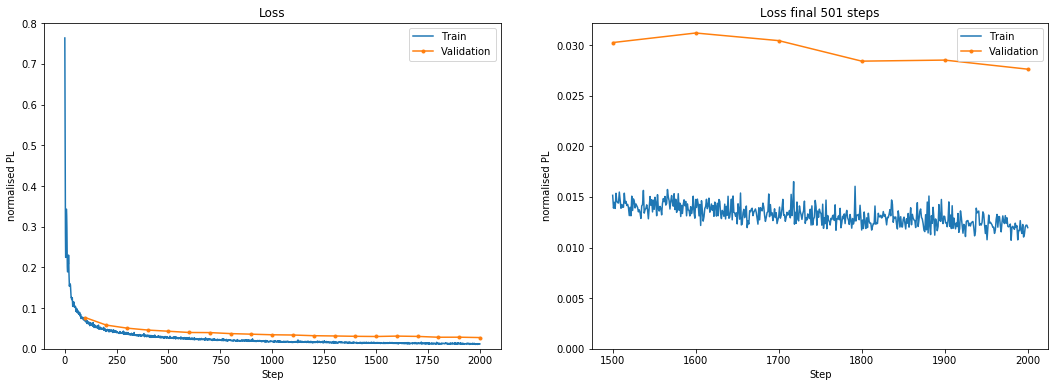

100/100 [==============================] - 21s 206ms/step - loss: 0.0123 - q0_loss: 3.1478e-04 - q1_loss: 6.2266e-04 - q2_loss: 0.0017 - q3_loss: 0.0020 - q4_loss: 0.0023 - q5_loss: 0.0022 - q6_loss: 0.0019 - q7_loss: 8.1581e-04 - q8_loss: 4.8136e-04 - val_loss: 0.0276 - val_q0_loss: 0.0011 - val_q1_loss: 0.0016 - val_q2_loss: 0.0034 - val_q3_loss: 0.0040 - val_q4_loss: 0.0053 - val_q5_loss: 0.0050 - val_q6_loss: 0.0043 - val_q7_loss: 0.0018 - val_q8_loss: 0.0012


In [45]:
# train
history = model.fit(train_batch_creator.flow(), epochs=20, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 1.3084705483800483, 'WSPL': 1.3084705483800483}


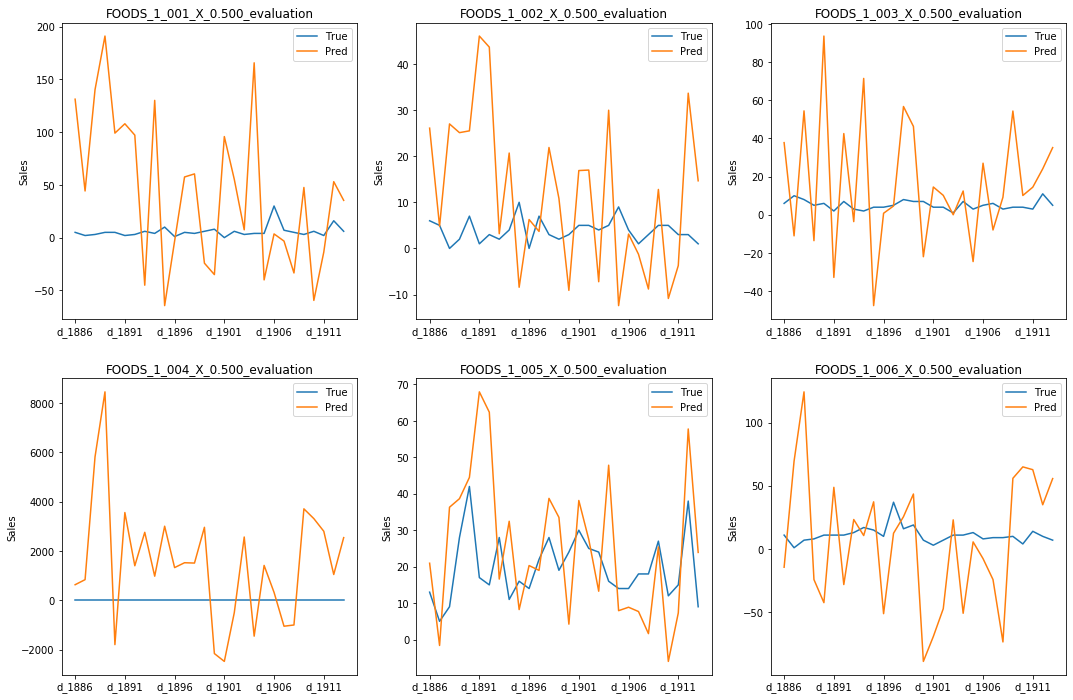

In [46]:
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

## Experiment: embedding size

In [48]:
import wandb
from wandb.keras import WandbCallback

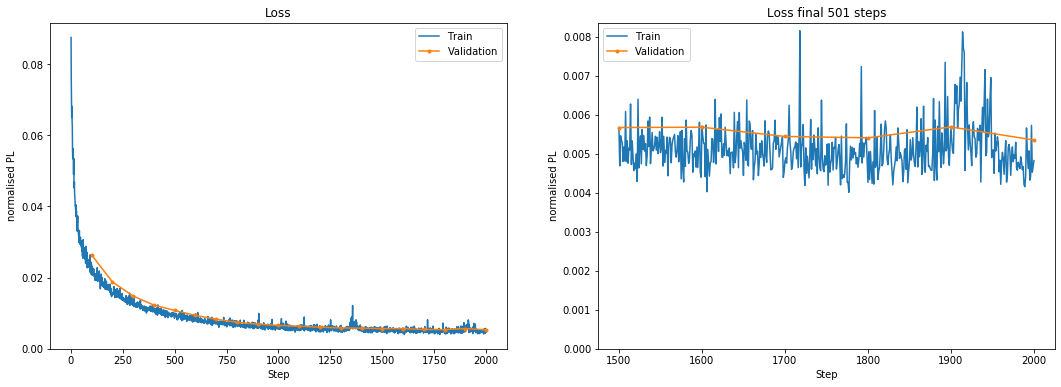

100/100 [==============================] - 34s 343ms/step - loss: 0.0053 - q0_loss: 6.7778e-05 - q1_loss: 2.0601e-04 - q2_loss: 7.5336e-04 - q3_loss: 9.3501e-04 - q4_loss: 0.0012 - q5_loss: 0.0010 - q6_loss: 8.4252e-04 - q7_loss: 2.6558e-04 - q8_loss: 1.0484e-04 - val_loss: 0.0053 - val_q0_loss: 7.1493e-05 - val_q1_loss: 2.0961e-04 - val_q2_loss: 7.4986e-04 - val_q3_loss: 9.3164e-04 - val_q4_loss: 0.0012 - val_q5_loss: 9.9751e-04 - val_q6_loss: 8.2965e-04 - val_q7_loss: 2.8268e-04 - val_q8_loss: 1.2349e-04
Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 0.2539632953613594, 'WSPL': 0.2539632953613594}


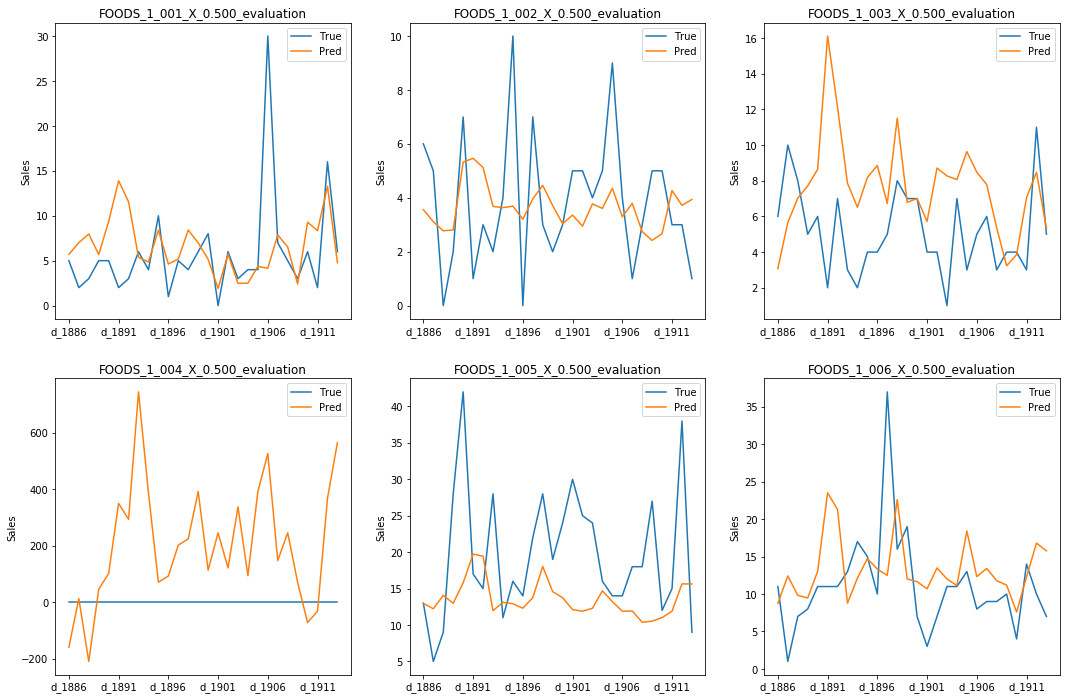

Unable to save ipython session history:
b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04+\x00\x00\x02\xbc\x08\x06\x00\x00\x00\xc6x5\x90\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b\x12\x01\xd2\xdd~\xfc\x00\x00\x008tEXtSoftware\x00matplotlib version3.1.3, http://matplotlib.org/\x80\x001D\x00\x00 \x00IDATx\x9c\xec\xddy\x9ccg}\xe7\xfb\xcf\xa3\xa5\xa4Z\xbb\xaaki\xdb\xdd\xee\xcd[\x1b\x1a0N\xc7\xb4cH\x08\xb6\x89\x13\x9c\x18\x18\x08\xc3v!!q2\xb9\x99$\x93d\x80d\xee\\\x1c\xc2\x840\x97\x90\x9b\x9b\x90xL08\x13b\'1K\x08\xc4l\x06\x070\xd8\xb8m\x8c\xf7n\xdb\xdd\xb6\xbb\xdd\xed\xee\xaa\xeeZU\xda\xf5\xdc?\x9esT*\x95J%\xd5"\x1dI\xdf\xf7\xeb\xa5\x97\xaat\x8e\xa4G\xb5<\xd2\xf9\x9d\xdf\xef\xf7\x18k-""""""""A\x11j\xf6\x00DDDDDDDDJ)X!"""""""\x81\xa2`\x85\x88\x88\x88\x88\x88\x88\x88\x04\x8a\x82\x15"""""""\x12(\nV\x88\x88\x88\x88\x88\x88\x88H\xa0(X!"""""""\x81\xa2`\x85\x88\x88\x88\x88\x88\x88\x88\x04\x8a\x82\x15"R\x951\xe6\xdd\xc6\x98\xefn\xd0co7\xc6\xcc\x19c\xc

In [50]:
options = [3, 10, 32, 100, 320, 1000, 3049]
WSPL_list = []

for embedding_size in options:
    # model setup
    embed_shapes_out = {'item_id': embedding_size}
    model = get_embed_dist_model(INP_SHAPE, embed_shapes_inp, embed_shapes_out, num_nodes=256)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
    model.summary()

    # setup metric tracking
    logger = Logger(val_batch_creator)
    wandb.init(project='m5forecast', name="Entity-embedding-item-id-{}".format(embedding_size),
               config=embed_shapes_out)
    
    # train model
    history = model.fit(train_batch_creator.flow(), epochs=20, steps_per_epoch=100,
                        validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                        callbacks=[logger, WandbCallback()])
    
    # calculate WSPL
    metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
    WSPL_list.append(metrics['WSPL'])

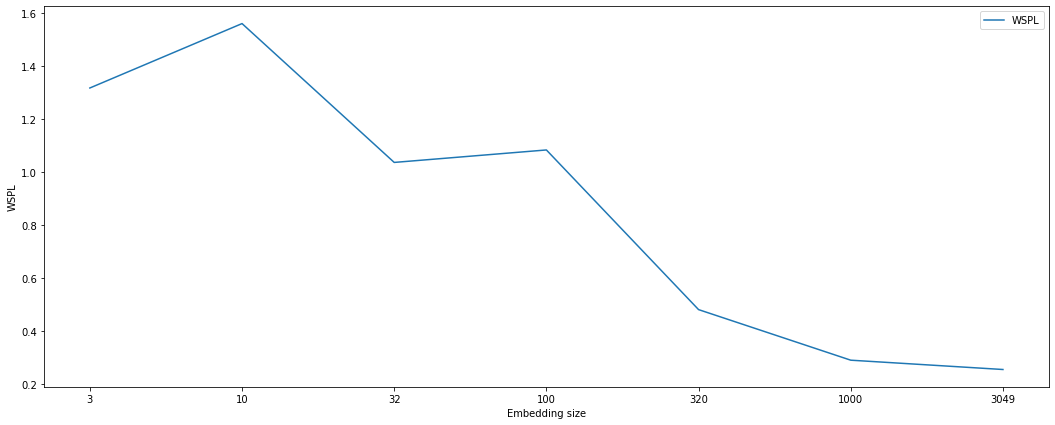

In [52]:
labels = options
f, ax = plt.subplots(1, 1, figsize=(18, 7))
ax.plot(WSPL_list, label="WSPL")
if labels is not None:
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
ax.set_ylabel("WSPL")
ax.set_xlabel("Embedding size")
ax.legend()
plt.show()

## Experiment: model size, no embedding

In [55]:
batch_size, labels = 1024, ['demand']
train_batch_creator = BatchCreator(x_train, batch_size=batch_size, features=features, labels=labels, 
                                   categorical_features=available_cat_features, embedding_features=None)
val_batch_creator = BatchCreator(x_val, batch_size=batch_size, features=features, labels=labels, 
                                 categorical_features=available_cat_features, embedding_features=None,
                                 ensure_all_samples=True, shuffle=False)

In [56]:
x, y = next(train_batch_creator.flow())

In [60]:
INP_SHAPE = x.shape[1]
INP_SHAPE

3230

#### Width

In [ ]:
options = [256, 512, 1024]
WSPL_list = []
logger_list = []

for num_nodes in options:
    # model setup
    model = get_simple_dist_model(INP_SHAPE, num_nodes=num_nodes)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
    model.summary()
    
    # setup metric tracking
    logger = Logger(val_batch_creator)
    wandb.init(project='m5forecast', name="Model-size-{}".format(num_nodes))
    
    # train model
    history = model.fit(train_batch_creator.flow(), epochs=30, steps_per_epoch=100,
                        validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                        callbacks=[logger, WandbCallback()])
    
    # calculate WSPL and save metrics
    metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
    WSPL_list.append(metrics['WSPL'])
    logger_list.append(logger)

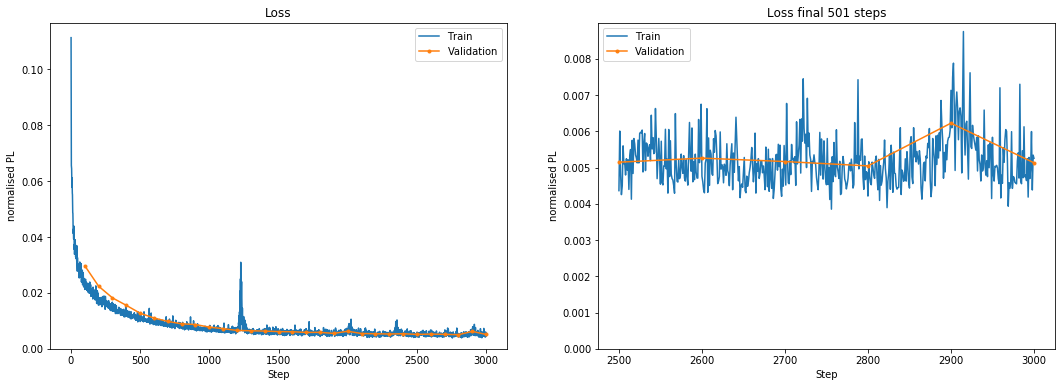

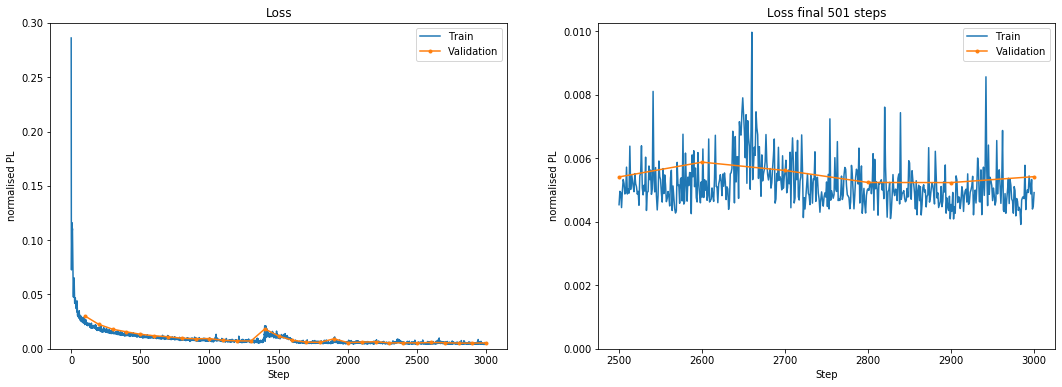

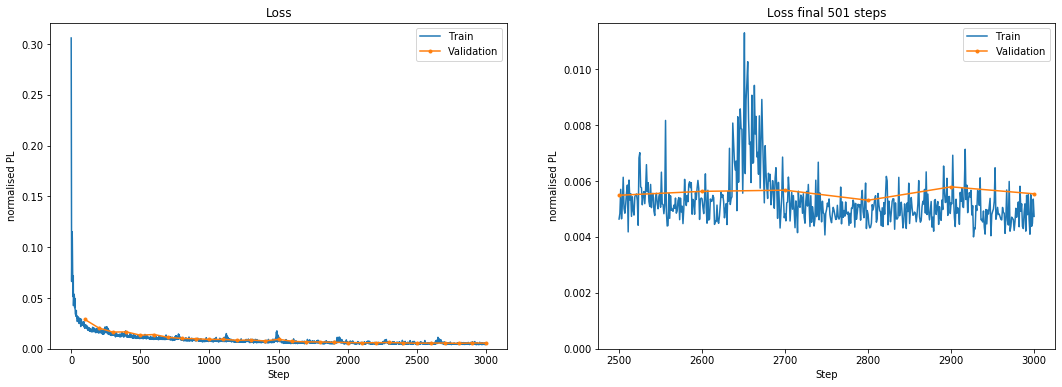

In [63]:
for logger in logger_list:
    logger.plot(clear=False)

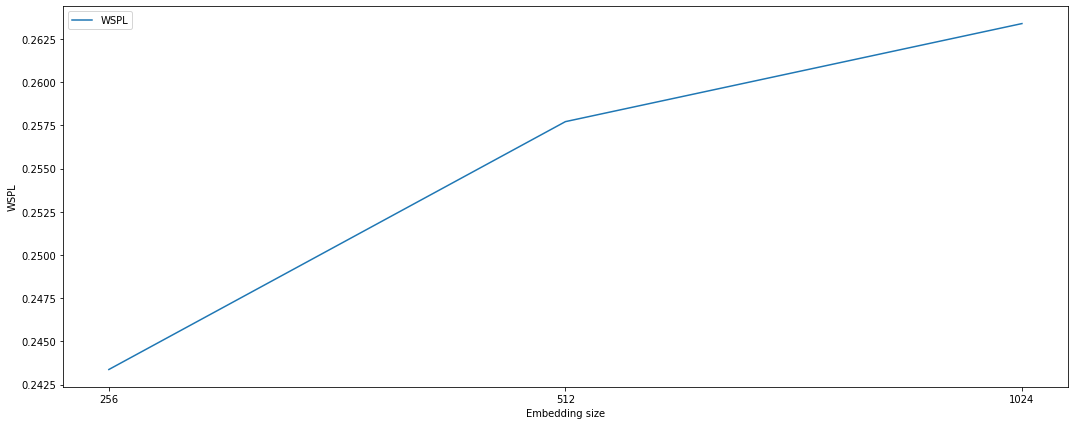

In [62]:
labels = options
f, ax = plt.subplots(1, 1, figsize=(18, 7))
ax.plot(WSPL_list, label="WSPL")
if labels is not None:
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
ax.set_ylabel("WSPL")
ax.legend()
plt.show()

#### Depth

In [ ]:
options = [64, 128, 256]
WSPL_list = []
logger_list = []

for num_nodes in options:
    # model setup
    model = get_simple_dense_model(INP_SHAPE, num_nodes=num_nodes, bottleneck_nodes=9)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
    model.summary()
    
    # setup metric tracking
    logger = Logger(val_batch_creator)
    wandb.init(project='m5forecast', name="Dense-size-{} (bottleneck 9)".format(num_nodes))
    
    # train model
    history = model.fit(train_batch_creator.flow(), epochs=30, steps_per_epoch=100,
                        validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                        callbacks=[logger, WandbCallback()])
    
    # calculate WSPL and save metrics
    metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
    WSPL_list.append(metrics['WSPL'])
    logger_list.append(logger)

In [ ]:
labels = options
f, ax = plt.subplots(1, 1, figsize=(18, 7))
ax.plot(WSPL_list, label="WSPL")
if labels is not None:
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
ax.set_ylabel("WSPL")
ax.set_xlabel("Dense nodes")
ax.legend()
plt.show()

In [ ]:
for logger in logger_list:
    logger.plot(clear=False)

## Experiment: Dense

#### Dense width

In [ ]:
options = [64, 128, 256, 512, 1024]
# WSPL_list = []
# logger_list = []

for num_nodes in options:
    # model setup
    model = get_simple_dense_model(INP_SHAPE, num_nodes=num_nodes, bottleneck_nodes=9)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
    model.summary()
    
    # setup metric tracking
    logger = Logger(val_batch_creator)
    wandb.init(project='m5forecast', name="Dense-size-{} (bottleneck 9)".format(num_nodes))
    
    # train model
    history = model.fit(train_batch_creator.flow(), epochs=30, steps_per_epoch=100,
                        validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                        callbacks=[logger, WandbCallback()])
    
    # calculate WSPL and save metrics
    metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
    WSPL_list.append(metrics['WSPL'])
    logger_list.append(logger)

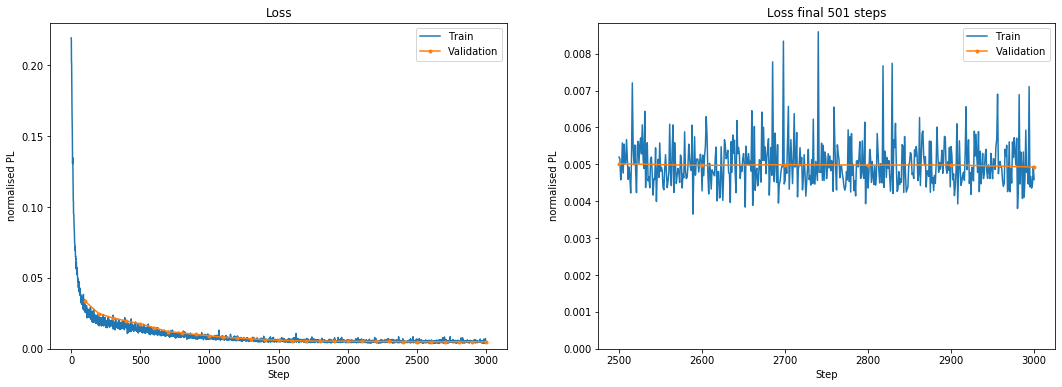

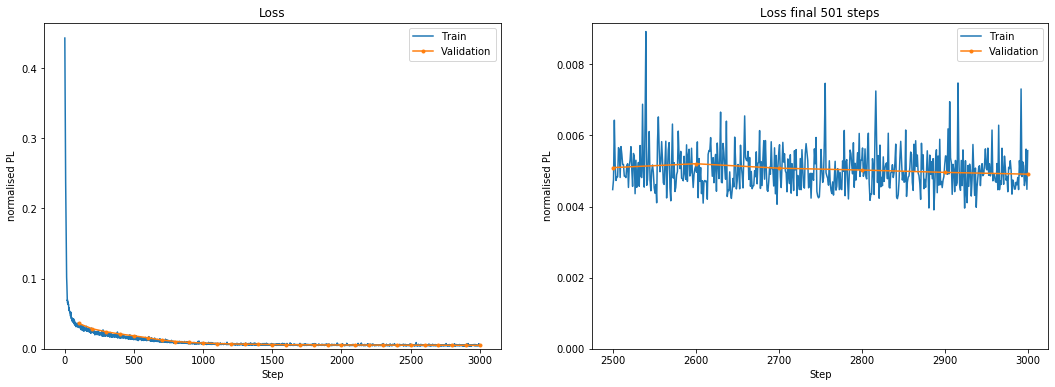

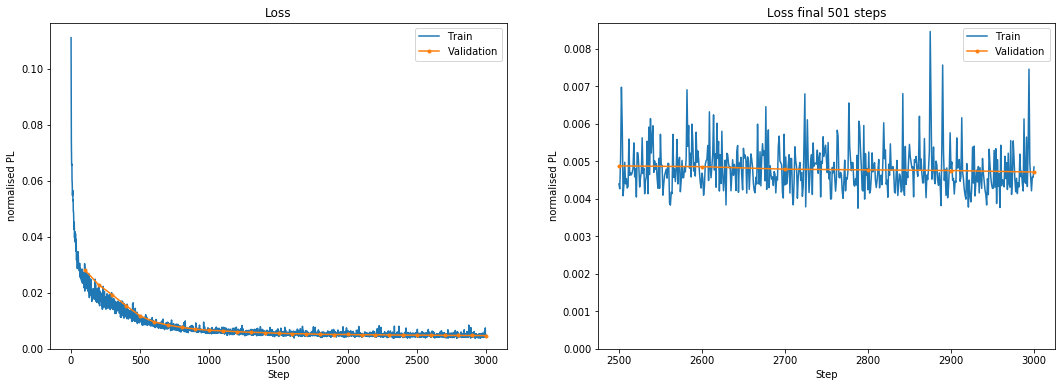

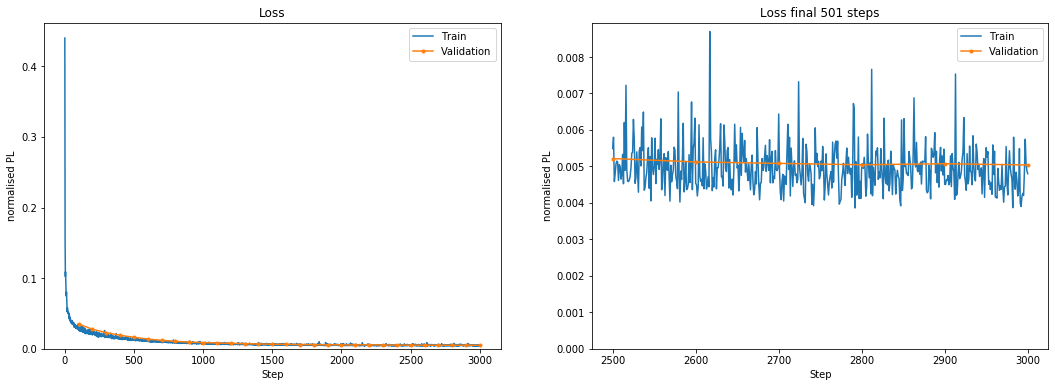

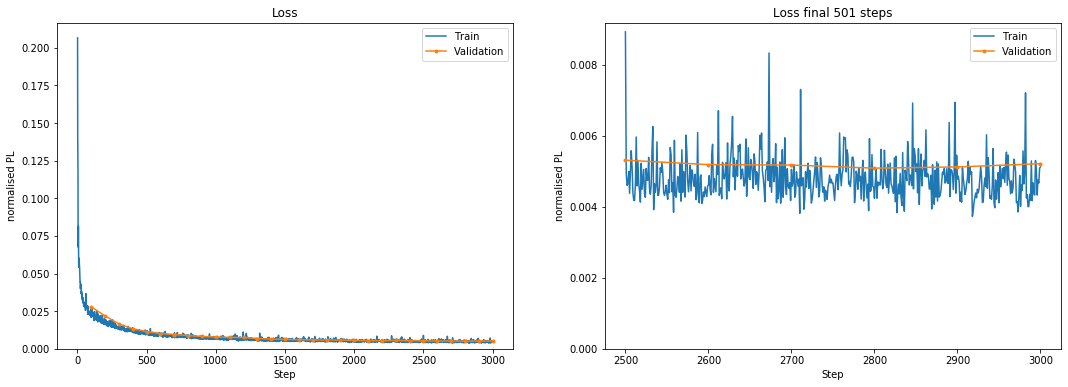

In [70]:
for logger in logger_list:
    logger.plot(clear=False)

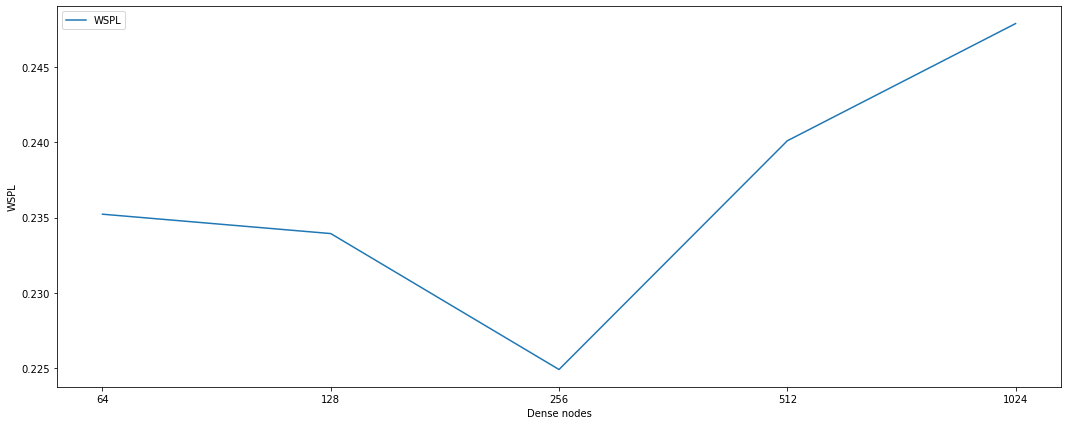

In [71]:
labels = options
f, ax = plt.subplots(1, 1, figsize=(18, 7))
ax.plot(WSPL_list, label="WSPL")
if labels is not None:
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
ax.set_ylabel("WSPL")
ax.set_xlabel("Dense nodes")
ax.legend()
plt.show()

#### Dense depth

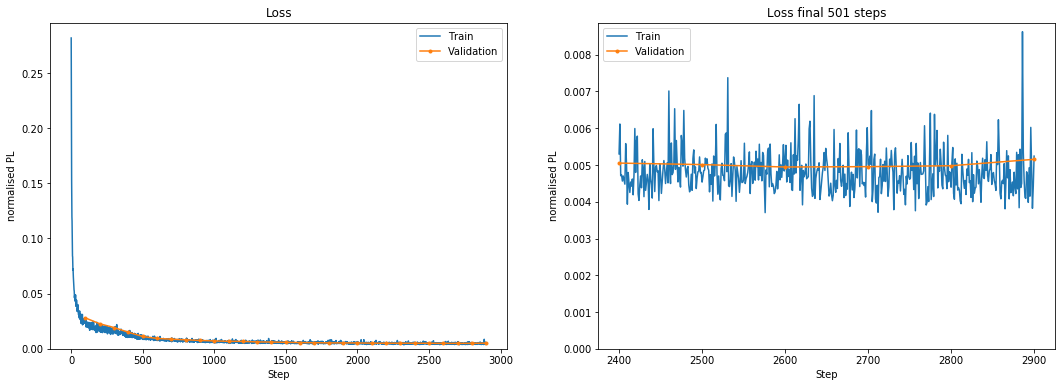

100/100 [==============================] - 42s 416ms/step - loss: 0.0047 - q0_loss: 4.3485e-05 - q1_loss: 1.5452e-04 - q2_loss: 6.4137e-04 - q3_loss: 8.1255e-04 - q4_loss: 0.0010 - q5_loss: 9.1251e-04 - q6_loss: 7.4591e-04 - q7_loss: 2.5436e-04 - q8_loss: 9.9692e-05 - val_loss: 0.0052 - val_q0_loss: 4.9265e-05 - val_q1_loss: 1.9297e-04 - val_q2_loss: 6.9336e-04 - val_q3_loss: 9.1737e-04 - val_q4_loss: 0.0012 - val_q5_loss: 9.4184e-04 - val_q6_loss: 8.3983e-04 - val_q7_loss: 2.5853e-04 - val_q8_loss: 8.3801e-05
Epoch 30/30
 48/100 [=============>................] - ETA: 15s - loss: 0.0048 - q0_loss: 4.2933e-05 - q1_loss: 1.5710e-04 - q2_loss: 6.5302e-04 - q3_loss: 8.2240e-04 - q4_loss: 0.0011 - q5_loss: 9.1971e-04 - q6_loss: 7.5748e-04 - q7_loss: 2.5944e-04 - q8_loss: 1.0028e-04

In [ ]:
options = [4, 7, 10, 13]
WSPL_list = []
logger_list = []

for num_layers in options:
    # model setup
    model = get_simple_dense_model(INP_SHAPE, num_nodes=256, num_layers=num_layers, bottleneck_nodes=9)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
    model.summary()
    
    # setup metric tracking
    logger = Logger(val_batch_creator)
    wandb.init(project='m5forecast', name="Model-depth-{} (x*256, 9)".format(num_layers))
    
    # train model
    history = model.fit(train_batch_creator.flow(), epochs=30, steps_per_epoch=100,
                        validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                        callbacks=[logger, WandbCallback()])
    
    # calculate WSPL and save metrics
    metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
    WSPL_list.append(metrics['WSPL'])
    logger_list.append(logger)

#### Train more with higher lr

In [72]:
train_batch_creator.__len__()

2090

In [74]:

def get_simple_dense_model(inp_shape, num_nodes=64, num_layers=3, bottleneck_nodes=2):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp

    # add dense layers
    for i in range(num_layers):
        x = Dense(num_nodes, activation="relu")(x)
        x = Dense(num_nodes, activation="relu")(x)
        x = Dense(num_nodes, activation="relu")(x)

    x = Dense(bottleneck_nodes)(x)  # represents mu, sigma

    out_q0 = Dense(1, name="q0")(x)
    out_q1 = Dense(1, name="q1")(x)
    out_q2 = Dense(1, name="q2")(x)
    out_q3 = Dense(1, name="q3")(x)
    out_q4 = Dense(1, name="q4")(x)
    out_q5 = Dense(1, name="q5")(x)
    out_q6 = Dense(1, name="q6")(x)
    out_q7 = Dense(1, name="q7")(x)
    out_q8 = Dense(1, name="q8")(x)

    model = Model(inputs=inp, outputs=[out_q0, out_q1, out_q2, out_q3, out_q4, out_q5, out_q6, out_q7, out_q8])

    return model


In [73]:
num_nodes = 256

model = get_simple_dense_model(INP_SHAPE, num_nodes=num_nodes, bottleneck_nodes=9)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=losses)
model.summary()

# setup metric tracking
logger = Logger(val_batch_creator)
wandb.init(project='m5forecast', name="Dense(256, 9) w/ lr 1e-3".format(num_nodes))

# train model
history = model.fit(train_batch_creator.flow(), epochs=100, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger, WandbCallback()])

# calculate WSPL and save metrics
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3230)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          827136      input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          65792       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          65792       dense_1[0][0]                    
______________________________________________________________________________________________

Train for 100 steps, validate for 84 steps
Epoch 1/100
54/84 [==================>...........] - ETA: 4s - loss: 0.0246 - q0_loss: 1.4045e-04 - q1_loss: 0.0013 - q2_loss: 0.0026 - q3_loss: 0.0036 - q4_loss: 0.0042 - q5_loss: 0.0045 - q6_loss: 0.0047 - q7_loss: 0.0023 - q8_loss: 0.0011

KeyboardInterrupt: 